<a href="https://colab.research.google.com/github/charithcherry/Internship-and-College-Repo-/blob/master/ML%20Ground/Types%20of%20Recommender%20systems/Different_type_of_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [3]:
!ls

 bento_service_content_based.py      'Online Retail.xlsx'
 bento_service.py		      Placement_Data_Full_Class.csv
 bento_service_recommender.py	      product_descriptions.csv
 finalized_model.sav		      profiler_books_metadata_1.html
 goodreads_books_poetry.json	      profiler_books_metadata_2.html
 goodreads_interactions_poetry.json   __pycache__
 moviedata			      ratings_Beauty.csv
 movies.csv			      Retail_before_preprocessing.html



## **Product popularity based recommendation** 
* Popularity based are a great strategy to target the new customers with the most popular products sold on a business's website and is very useful to cold start a recommendation engine.

* **Dataset : **[Amazon product review dataset](https://www.kaggle.com/skillsmuggler/amazon-ratings)

#### Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

#### Loading the dataset

In [ ]:
amazon_ratings = pd.read_csv('ratings_Beauty.csv')
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [ ]:
amazon_ratings.shape

(2023070, 4)

In [ ]:
popular_products = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


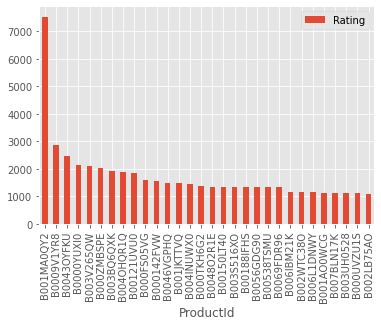

In [ ]:
most_popular.head(30).plot(kind = "bar")

## **Utility Matrix based on products sold and user reviews**
**Utility Matrix : **An utlity matrix is consists of all possible user-item preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all teh items in the list, hence, most of the values are unknown.

In [ ]:
# Subset of Amazon Ratings

amazon_ratings1 = amazon_ratings.head(10000)

In [ ]:
ratings_utility_matrix = amazon_ratings1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,130414674X,1304168522,1304174778,1304174867,1304174905,1304196046,1304196062,1304196070,1304196135,1304351475,1304482596,1304482634,1304482685,1304488608,1304495396,1304511073,1304511081,1304511111,130451112X,1304511138,1304511146,1304511154,1304622193,1304622223,1304622428,1304622452,1304622460,1304622622,1304622657,1304622665,...,B000052YMU,B000052YMV,B000052YMX,B000052YN5,B000052YN6,B000052YN7,B000052YN9,B000052YNA,B000052YNB,B000052YNE,B000052YOC,B000052YOG,B000052YOL,B000052YOM,B000052YOQ,B000052YOR,B000052YOS,B000052YOT,B000052YOU,B000052YOV,B000052YOX,B000052YOY,B000052YOZ,B000052YP0,B000052YP1,B000052YP3,B000052YP4,B000052YP6,B000052YP9,B000052YPC,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


As expected, the utility matrix obtained above is sparse, so we  fill the unknown values wth 0.

In [ ]:
ratings_utility_matrix.shape

(9697, 886)

Transposing the matrix

In [ ]:
X = ratings_utility_matrix.T
X.head()

UserId,A00205921JHJK5X9LNP42,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,A059547920Q3LZVFHLPI3,A07410232KYRFR25CIUGJ,A082796624UNM47DSAI6K,A0864963DOAY7LXGS5I6,A0870685EP51H0X8LFFU,A100AM334XZS3V,A100GYE1W4OXZ8,A100UD67AHFODS,A101GN97A47S1P,A10205RFE66H1R,A1029IITTU8289,A102LFZGD4MJXV,A1034GEUA8ZVFR,A103BJIOJSDJL1,A103FNP25GNMPH,A103PIRYKWQKR7,A103QH6R6A4FT1,A103QUZ016BQNJ,A103U3KR4L2ZXT,A1041053SID37WN8GTT8,A104CBA4A4HYOF,A104D62WJII6KP,A105C73RQ4YGCW,A1087Y8RJ4D422,A108HJD2ESJXUY,A108JE8E0CK1G3,A108LMMYNGL89M,A108V4O9Z78DB5,A10BXWWQPUDNCW,A10BZV61MNLBZD,A10C03UY4QEHJT,A10FEMX3ROQPTD,A10FXC2G4J7V6J,A10G0QS2B1S9J2,...,AZD8DMTDUVUDL,AZDHBUN122II4,AZDIZ674B4GVL,AZEIM64I6C7WW,AZG4Z8O02E9H4,AZG82XLVC98Y3,AZGGH4GS18RUN,AZGNXVV2ENZW8,AZHA72ZW5U8,AZJ8PVOKAJS5,AZJSE6RVOUU0E,AZKWPIG6RXKNG,AZLE2XFH3JUNG,AZLXFHIJ0J4VQ,AZLYAJ8XE443K,AZM0CLX6A5FFB,AZM3MWNYYPF0J,AZMS0XGWN43LW,AZMW54GPQ0WTQ,AZMWU0SO3H0DG,AZN3PS2PIZV06,AZNACMHVBRB5P,AZNOO10AO8G8V,AZP9CW7C6G8XO,AZPJ8ZDUN5HY8,AZSCK9QG6SMSB,AZSY5LHJ6LN7F,AZUFBU43ILNPC,AZUOLPXIGPG5O,AZW0RIARTTWWR,AZW1HXXYAC15B,AZWRTJPN7NXT,AZWTXHXZXFAYP,AZYQEFB9Y5N22,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
ProductId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0205616461,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0558925278,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0733001998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0737104473,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0762451459,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(886, 9697)

Unique products in subset of data

In [ ]:
X1 = X

### Decomposing the Matrix

In [ ]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(886, 10)

### Correlation Matrix

In [ ]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(886, 886)

correlation_matrix

### Isolating Product ID # 6117036094 from the Correlation Matrix

Assuming the customer buys Product ID # 6117036094 (randomly chosen)

In [ ]:
X.index[99]

'6117036094'

Index # of product ID purchased by customer

In [ ]:
i = "6117036094"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

99

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(886,)

### Recommending top 10 highly correlated products in sequence

In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:9]

['0762451459',
 '1304146537',
 '1304168522',
 '1304196070',
 '1304482596',
 '1304488608',
 '1304495396',
 '130451112X',
 '1304622428']

**Product Id # **
Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website. 

## **Item Item based recommendation system**
* For a business without any user-item purchase history, a search engine based recommendation system can be designed for users. The product recommendations can be based on textual clustering analysis given in product description.
* **Dataset : **[Home Depot's dataset with product dataset.](https://www.kaggle.com/c/home-depot-product-search-relevance/data)

In [ ]:
# Importing libraries

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
product_descriptions = pd.read_csv('product_descriptions.csv')
product_descriptions.shape

(124428, 2)

#### Checking for missing values

In [ ]:
# Missing values

product_descriptions = product_descriptions.dropna()
product_descriptions.shape
product_descriptions.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [ ]:
product_descriptions1 = product_descriptions.head(500)
# product_descriptions1.iloc[:,1]

product_descriptions1["product_description"].head(10)

0    Not only do angles make joints stronger, they ...
1    BEHR Premium Textured DECKOVER is an innovativ...
2    Classic architecture meets contemporary design...
3    The Grape Solar 265-Watt Polycrystalline PV So...
4    Update your bathroom with the Delta Vero Singl...
5    Achieving delicious results is almost effortle...
6    The Quantum Adjustable 2-Light LED Black Emerg...
7    The Teks #10 x 1-1/2 in. Zinc-Plated Steel Was...
8    Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
9    Valley View Industries Metal Stakes (4-Pack) a...
Name: product_description, dtype: object

#### Feature extraction from product descriptions

Converting the text in product description into numerical data for analysis

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["product_description"])
X1

<500x8932 sparse matrix of type '<class 'numpy.float64'>'
	with 34817 stored elements in Compressed Sparse Row format>

#### Visualizing product clusters in subset of data

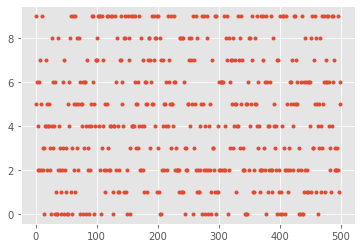

In [ ]:
# Fitting K-Means to the dataset

X=X1

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()


F

In [ ]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print('\n')

#### Top words in each cluster based on product description

In [ ]:
# # Optimal clusters is 

true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 led
 light
 lighting
 leds
 power
 fixture
 protection
 volt
 plan
 depot


Cluster 1:
 post
 fence
 kit
 ft
 screen
 posts
 gate
 wall
 vinyl
 installation


Cluster 2:
 ft
 air
 light
 help
 fan
 easy
 room
 control
 home
 finish


Cluster 3:
 metal
 steel
 screw
 drill
 screws
 gauge
 hole
 20
 tool
 lithium


Cluster 4:
 door
 design
 indoor
 projects
 easy
 use
 aluminum
 outdoor
 cut
 finish


Cluster 5:
 wood
 bamboo
 natural
 patio
 furniture
 frame
 collection
 fabric
 outdoor
 window


Cluster 6:
 insulation
 water
 tape
 heater
 easy
 fiberglass
 gas
 use
 oil
 year


Cluster 7:
 tool
 bag
 duty
 heavy
 ft
 vary
 store
 water
 product
 pockets


Cluster 8:
 water
 toilet
 gal
 flush
 easy
 watering
 bowl
 piece
 offers
 handle


Cluster 9:
 rug
 easy
 tool
 pliers
 cleaning
 attachment
 helps
 suction
 slightly
 brush




#### Predicting clusters based on key search words

In [ ]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

* **Keyword : ** cutting tool

In [ ]:
show_recommendations("cutting tool")

Cluster 7:
 tool
 bag
 duty
 heavy
 ft
 vary
 store
 water
 product
 pockets




* **Keyword : **books

In [ ]:
show_recommendations("books")

Cluster 2:
 ft
 air
 light
 help
 fan
 easy
 room
 control
 home
 finish




* **Keyword : **steel drill

In [ ]:
show_recommendations("steel drill")

Cluster 3:
 metal
 steel
 screw
 drill
 screws
 gauge
 hole
 20
 tool
 lithium




In case a word appears in multiple clusters, the algorithm chooses the cluster with the highest frequency of occurance of the word.

* **Keyword : **water

In [ ]:
show_recommendations("tool")

Cluster 7:
 tool
 bag
 duty
 heavy
 ft
 vary
 store
 water
 product
 pockets




## Content Based Recommender System

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def get_title_from_index(index):
    return df[df.index==index]["title"].values[0]

def get_index_from_title(title):
    return df[df.title==title]["index"].values[0]

In [ ]:
df=pd.read_csv("movies.csv")
df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [ ]:
df.shape

(4803, 24)

In [ ]:
features=['keywords','cast','genres','director']

for feature in features:
    df[feature]=df[feature].fillna('')


In [ ]:
def combine_features(row):
    try:
        return row['keywords']+" "+row['cast']+" "+row['genres']+" "+row['director']
    except:
        print("error",row)


In [ ]:
df['combined features']=df.apply(combine_features,axis=1)

In [ ]:
cv=CountVectorizer()
cm=cv.fit_transform(df['combined features'])
cs=cosine_similarity(cm)


In [ ]:
movie=input("Enter movie: ")
movie_index=get_index_from_title(movie)
sm=list(enumerate(cs[movie_index]))
sorted_sm=sorted(sm,key=lambda x:x[1],reverse=True)

Enter movie: Avatar


In [ ]:
i=0
for m in sorted_sm:
    print(get_title_from_index(m[0]))
    i=i+1
    if i==20:
        break

Avatar
Guardians of the Galaxy
Aliens
Star Wars: Clone Wars: Volume 1
Star Trek Into Darkness
Star Trek Beyond
Alien
Lockout
Jason X
The Helix... Loaded
Moonraker
Planet of the Apes
Galaxy Quest
Gravity
Alien³
Jupiter Ascending
The Wolverine
Silent Running
Zathura: A Space Adventure
Trekkies


## **Knowledge Based Recommender System**
https://ilmoirfan.com/developing-knowledge-based-recommender-system/

In [ ]:
data =pd.read_csv('movies.csv')
data.head(5)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [ ]:
data=data[['original_title','genres','release_date','runtime','vote_average','vote_count']]

In [ ]:
data.head()



,original_title,genres,release_date,runtime,vote_average,vote_count
0,Avatar,Action Adventure Fantasy Science Fiction,2009-12-10,162.0,7.2,11800
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action,2007-05-19,169.0,6.9,4500
2,Spectre,Action Adventure Crime,2015-10-26,148.0,6.3,4466
3,The Dark Knight Rises,Action Crime Drama Thriller,2012-07-16,165.0,7.6,9106
4,John Carter,Action Adventure Science Fiction,2012-03-07,132.0,6.1,2124


In [ ]:
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')


In [ ]:
data['year']=data['release_date'].apply(lambda x: str(x).split('-')[0] if x!=np.nan else np.nan)

In [ ]:
def convert_int(x):
  try:
    return int(x)
  except:
    return 0  

In [ ]:
data['year']=data['year'].apply(convert_int)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   original_title  4803 non-null   object        
 1   genres          4775 non-null   object        
 2   release_date    4802 non-null   datetime64[ns]
 3   runtime         4801 non-null   float64       
 4   vote_average    4803 non-null   float64       
 5   vote_count      4803 non-null   int64         
 6   year            4803 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 262.8+ KB


In [ ]:
data=data.drop('release_date',axis=1)

In [ ]:
data.head()

,original_title,genres,runtime,vote_average,vote_count,year
0,Avatar,Action Adventure Fantasy Science Fiction,162.0,7.2,11800,2009
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action,169.0,6.9,4500,2007
2,Spectre,Action Adventure Crime,148.0,6.3,4466,2015
3,The Dark Knight Rises,Action Crime Drama Thriller,165.0,7.6,9106,2012
4,John Carter,Action Adventure Science Fiction,132.0,6.1,2124,2012


In [ ]:
data.iloc[0]['genres']

'Action Adventure Fantasy Science Fiction'

In [ ]:
from ast import literal_eval



In [ ]:
data['genres']=data['genres'].fillna('[]')

In [ ]:
def Convert(string):
    li = list(string.split(" "))
    return li
def Convertc(string):
    li = list(string.split(","))
    return li

In [ ]:
data['genres'] = data['genres'].apply(Convert)

In [ ]:
data.head()

,original_title,genres,runtime,vote_average,vote_count,year
0,Avatar,"[Action, Adventure, Fantasy, Science, Fiction]",162.0,7.2,11800,2009
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",169.0,6.9,4500,2007
2,Spectre,"[Action, Adventure, Crime]",148.0,6.3,4466,2015
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",165.0,7.6,9106,2012
4,John Carter,"[Action, Adventure, Science, Fiction]",132.0,6.1,2124,2012


In [ ]:
s=data.apply(lambda x:pd.Series(x['genres']),axis=1).stack().reset_index(level=1,drop=True)

In [ ]:
s.name='genre'


In [ ]:
gen_df=data.drop('genres',axis=1).join(s)

In [ ]:
gen_df["genre"] = gen_df["genre"].str.lower()


In [ ]:
gen_df.head(10)

,original_title,runtime,vote_average,vote_count,year,genre
0,Avatar,162.0,7.2,11800,2009,action
0,Avatar,162.0,7.2,11800,2009,adventure
0,Avatar,162.0,7.2,11800,2009,fantasy
0,Avatar,162.0,7.2,11800,2009,science
0,Avatar,162.0,7.2,11800,2009,fiction
1,Pirates of the Caribbean: At World's End,169.0,6.9,4500,2007,adventure
1,Pirates of the Caribbean: At World's End,169.0,6.9,4500,2007,fantasy
1,Pirates of the Caribbean: At World's End,169.0,6.9,4500,2007,action
2,Spectre,148.0,6.3,4466,2015,action
2,Spectre,148.0,6.3,4466,2015,adventure


In [ ]:
def chart_building(genre,low_time,high_time,low_year,high_year,gen_df,percentile=0.8):
  movies=gen_df.copy()
  movies=movies[(movies['genre']==genre) &
                (movies['runtime']>=low_time) &
                (movies['runtime']<=high_time) &
                (movies['year']>=low_year) &
                (movies['year']<=high_year)]

  C=movies['vote_average'].mean()
  m=movies['vote_count'].quantile(percentile)
  q_movies=movies.copy().loc[movies['vote_count']>=m]  
  q_movies['score']=q_movies.apply(lambda x:(x['vote_count']/(x['vote_count']+m)*x['vote_average'])+(m/(m+x['vote_count'])*C),axis=1)
  q_movies=q_movies.sort_values('score',ascending=False)
  return q_movies  


### Input-Output

In [ ]:
print("input preferred genre")
genre=input()
print("input shortest duration")
low_time=int(input())
print("input lonest duration")
high_time=int(input())
print("input earliest year")
low_year=int(input())
print("input latest year")
high_year=int(input())
KBS=chart_building(genre,low_time,high_time,low_year,high_year,gen_df).head()
KBS=KBS.original_title
KBS=KBS.reset_index(drop=True)
KBS

input preferred genre
drama
input shortest duration
20
input lonest duration
160
input earliest year
1990
input latest year
2013


0    The Shawshank Redemption
1                  Fight Club
2             The Dark Knight
3                Forrest Gump
4                  GoodFellas
Name: original_title, dtype: object

## **Demographic Filtering**

In [ ]:
movies =pd.read_csv('movies.csv')
movies.head(5)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [ ]:
m = movies['vote_count'].quantile(0.9)
C = movies['vote_average'].mean()

In [ ]:
def imbd_weighted_ratings(movies, m=m, C=C):
    v =movies["vote_count"]
    R =movies["vote_average"]
    left_term = v /(v + m)
    right_term = m /(v + m) 
    return left_term* R + right_term* C

In [ ]:
qualified_movies  = movies.copy().loc[movies["vote_count"] >= m]


In [ ]:
qualified_movies["imdb_score"] = qualified_movies.apply(imbd_weighted_ratings, axis = 1)

In [ ]:
qualified_movies.head(2)


,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director,imdb_score
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron,7.050669
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski,6.665696


In [ ]:
qualified_movies.sort_values("imdb_score", ascending=False, inplace= True)


In [ ]:
filtered_qualified_movies = qualified_movies[['original_title', 'popularity', 'vote_count','vote_average', "imdb_score"]]


In [ ]:
filtered_qualified_movies.head()


,original_title,popularity,vote_count,vote_average,imdb_score
1881,The Shawshank Redemption,136.747729,8205,8.5,8.059258
662,Fight Club,146.757391,9413,8.3,7.939256
65,The Dark Knight,187.322927,12002,8.2,7.920020
3232,Pulp Fiction,121.463076,8428,8.3,7.904645
96,Inception,167.583710,13752,8.1,7.863239


In [ ]:
def get_recommendations(k):
    return filtered_qualified_movies[:k]['original_title']

In [ ]:
get_recommendations(5)


1881    The Shawshank Redemption
662                   Fight Club
65               The Dark Knight
3232                Pulp Fiction
96                     Inception
Name: original_title, dtype: object

In [ ]:
popular = movies.sort_values('popularity', ascending=False)


Text(0.5, 1.0, 'Popular Movies')

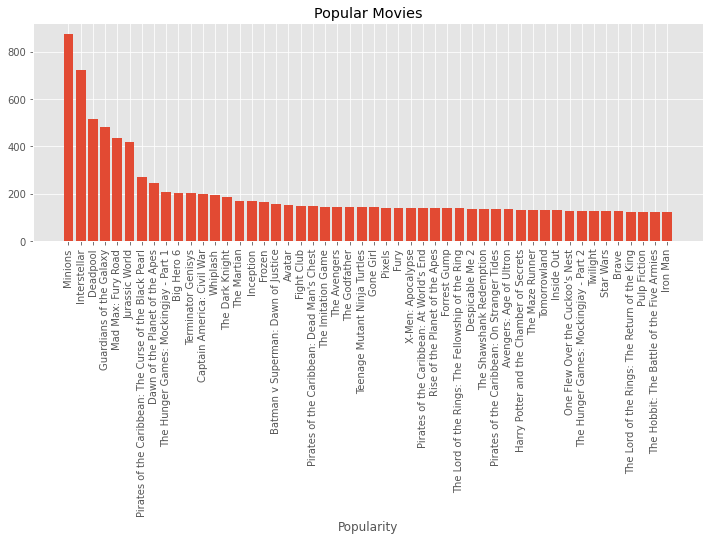

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.bar(popular['original_title'].head(50),popular['popularity'].head(50))
plt.xlabel("Popularity")
plt.xticks(rotation = 90)
plt.title("Popular Movies")

Text(0.5, 1.0, 'Popular Movies')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12392 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23563 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31070 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38560 missing from current font.
  font.set_

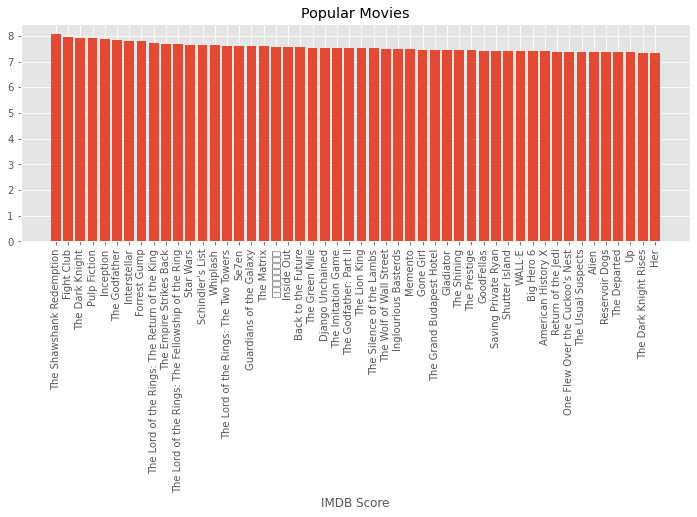

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.bar(qualified_movies['original_title'].head(50),qualified_movies['imdb_score'].head(50))
plt.xlabel("IMDB Score")
plt.xticks(rotation = 90)
plt.title("Popular Movies")

## **Meta Data based Recommender System**

In [ ]:
# cleaning data

movies.isnull().sum()

index                      0
budget                     0
genres                    28
homepage                3091
id                         0
keywords                 412
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
cast                      43
crew                       0
director                  30
dtype: int64

In [ ]:
movies = movies.dropna()


In [ ]:
movies.isnull().sum()


index                   0
budget                  0
genres                  0
homepage                0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
cast                    0
crew                    0
director                0
dtype: int64

In [ ]:
movies.head(2)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski


In [ ]:
features = ['cast', 'keywords', 'director', 'genres']

In [ ]:
movies['genres'] = movies['genres'].apply(Convert)

In [ ]:
movies['cast'] = movies['cast'].apply(Convertc)

In [ ]:
movies['keywords'] = movies['keywords'].apply(Convert)

In [ ]:
movies[features].head(5)


,cast,keywords,director,genres
0,[Sam Worthington Zoe Saldana Sigourney Weaver ...,"[culture, clash, future, space, war, space, co...",James Cameron,"[Action, Adventure, Fantasy, Science, Fiction]"
1,[Johnny Depp Orlando Bloom Keira Knightley Ste...,"[ocean, drug, abuse, exotic, island, east, ind...",Gore Verbinski,"[Adventure, Fantasy, Action]"
2,[Daniel Craig Christoph Waltz L\u00e9a Seydoux...,"[spy, based, on, novel, secret, agent, sequel,...",Sam Mendes,"[Action, Adventure, Crime]"
3,[Christian Bale Michael Caine Gary Oldman Anne...,"[dc, comics, crime, fighter, terrorist, secret...",Christopher Nolan,"[Action, Crime, Drama, Thriller]"
4,[Taylor Kitsch Lynn Collins Samantha Morton Wi...,"[based, on, novel, mars, medallion, space, tra...",Andrew Stanton,"[Action, Adventure, Science, Fiction]"


In [ ]:
def metadata_collection(x):
#     colec = " "
    return  ' '.join (x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movies['metadata_collection'] = movies.apply(metadata_collection, axis=1)

In [ ]:
movies.head(3)


,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director,metadata_collection
0,0,237000000,"[Action, Adventure, Fantasy, Science, Fiction]",http://www.avatarmovie.com/,19995,"[culture, clash, future, space, war, space, co...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,[Sam Worthington Zoe Saldana Sigourney Weaver ...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron,culture clash future space war space colony so...
1,1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug, abuse, exotic, island, east, ind...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,[Johnny Depp Orlando Bloom Keira Knightley Ste...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski,ocean drug abuse exotic island east india trad...
2,2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based, on, novel, secret, agent, sequel,...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,[Daniel Craig Christoph Waltz L\u00e9a Seydoux...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes,spy based on novel secret agent sequel mi6 Dan...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies['metadata_collection'])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['original_title'])

In [ ]:
movies.head(3)


,level_0,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director,metadata_collection
0,0,0,237000000,"[Action, Adventure, Fantasy, Science, Fiction]",http://www.avatarmovie.com/,19995,"[culture, clash, future, space, war, space, co...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,[Sam Worthington Zoe Saldana Sigourney Weaver ...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron,culture clash future space war space colony so...
1,1,1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug, abuse, exotic, island, east, ind...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,[Johnny Depp Orlando Bloom Keira Knightley Ste...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski,ocean drug abuse exotic island east india trad...
2,2,2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based, on, novel, secret, agent, sequel,...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,[Daniel Craig Christoph Waltz L\u00e9a Seydoux...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes,spy based on novel secret agent sequel mi6 Dan...


In [ ]:
def get_recommendations(title, k):
    index = indices[title]
    
    similarity = list(enumerate(cosine_sim[index]))
    
    similarity = sorted(similarity, key=lambda x: x[1], reverse=True)
    similarity = similarity[1:k]
    
    movie_indices = [i[0] for i in similarity]
    
    return movies['original_title'].iloc[movie_indices]

In [ ]:
get_recommendations("Avatar", 5)


74      Guardians of the Galaxy
1118                      Alien
870                     Lockout
673                   Moonraker
Name: original_title, dtype: object

## **Hybrid Recommender System**

In [ ]:
!pip install lightfm

In [ ]:
!pip install scikit-optimize

In [ ]:
import pandas as pd
import os
from scipy.sparse import csr_matrix
import numpy as np
from IPython.display import display_html
import warnings

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline

from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM
from skopt import forest_minimize

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace(
        'table', 'table style="display:inline"'), raw=True)

In [ ]:
books_metadata = pd.read_json('goodreads_books_poetry.json', lines=True)
interactions = pd.read_json('goodreads_interactions_poetry.json', lines=True)

In [ ]:
books_metadata.columns.values


array(['isbn', 'text_reviews_count', 'series', 'country_code',
       'language_code', 'popular_shelves', 'asin', 'is_ebook',
       'average_rating', 'kindle_asin', 'similar_books', 'description',
       'format', 'link', 'authors', 'publisher', 'num_pages',
       'publication_day', 'isbn13', 'publication_month',
       'edition_information', 'publication_year', 'url', 'image_url',
       'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'], dtype=object)

In [ ]:
books_metadata.sample(2)


,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
14527,1933254815,1,[],US,eng,"[{'count': '30', 'name': 'to-read'}, {'count':...",,false,4.52,,[],Poetry. LGBT Studies. gowanus atropolis is an ...,Paperback,https://www.goodreads.com/book/show/10480725-g...,"[{'author_id': '5390831', 'role': ''}]",Ugly Duckling Presse,100,1,9781933254814,1,,2011,https://www.goodreads.com/book/show/10480725-g...,https://images.gr-assets.com/books/1297880419m...,10480725,29,15386152,gowanus atropolis,gowanus atropolis
6687,0393352250,1,[],US,eng,"[{'count': '86', 'name': 'to-read'}, {'count':...",,false,4.38,B00L4HAVGG,[],The Song of Songs; Ruth; Esther; Jonah; and Da...,Paperback,https://www.goodreads.com/book/show/25622867-s...,"[{'author_id': '62157', 'role': 'Translation'}]",W. W. Norton Company,256,8,9780393352252,2,,2016,https://www.goodreads.com/book/show/25622867-s...,https://images.gr-assets.com/books/1450005714m...,25622867,3,41629767,Strong As Death Is Love,Strong As Death Is Love


In [ ]:
books_metadata_selected = books_metadata[['book_id', 'average_rating', 'is_ebook', 'num_pages', 
                                          'publication_year', 'ratings_count', 'language_code']]
books_metadata_selected.sample(5)

,book_id,average_rating,is_ebook,num_pages,publication_year,ratings_count,language_code
17581,13284933,4.32,true,34,,36,spa
9462,1355591,4.12,false,123,1996,14,eng
9372,18856353,3.93,true,,,61,
20695,3117586,4.37,false,144,2008,306,
3519,15846877,3.19,false,242,2012,26,per


In [ ]:
import pandas_profiling
import numpy as np

# replace blank cells with NaN
books_metadata_selected.replace('', np.nan, inplace=True)

# not taking book_id into the profiler report
profile = pandas_profiling.ProfileReport(books_metadata_selected[['average_rating', 'is_ebook', 'num_pages', 
                                                                  'publication_year', 'ratings_count']])
profile.to_file('profiler_books_metadata_1.html')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
books_metadata_selected['num_pages'].replace(np.nan, -1, inplace=True)
books_metadata_selected['num_pages'] = pd.to_numeric(books_metadata_selected['num_pages'])
books_metadata_selected['num_pages'] = pd.cut(books_metadata_selected['num_pages'], bins=25)

# rounding ratings to neares .5 score
books_metadata_selected['average_rating'] = books_metadata_selected['average_rating'].apply(lambda x: round(x*2)/2)

# using pandas qcut method to convert fields into quantile-based discrete intervals
books_metadata_selected['ratings_count'] = pd.qcut(books_metadata_selected['ratings_count'], 25)

# replacing missing values to year 2100
books_metadata_selected['publication_year'].replace(np.nan, 2100, inplace=True)

# replacing missing values to 'unknown'
books_metadata_selected['language_code'].replace(np.nan, 'unknown', inplace=True)


# convert is_ebook column into 1/0 where true=1 and false=0
books_metadata_selected['is_ebook'] = books_metadata_selected.is_ebook.map(
    lambda x: 1.0*(x == 'true'))

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [ ]:
profile = pandas_profiling.ProfileReport(books_metadata_selected[['average_rating', 'is_ebook', 'num_pages', 
                                                        'publication_year', 'ratings_count']])
profile.to_file('profiler_books_metadata_2.html')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
books_metadata_selected.sample(5)


,book_id,average_rating,is_ebook,num_pages,publication_year,ratings_count,language_code
10463,8431208,4.0,0.0,"(-11.961, 437.44]",2011,"(285.0, 614.0]",eng
35224,11024292,5.0,0.0,"(-11.961, 437.44]",2100,"(7.0, 8.0]",unknown
34840,1817258,3.5,0.0,"(-11.961, 437.44]",1998,"(7.0, 8.0]",pol
19083,7049310,4.0,0.0,"(-11.961, 437.44]",1973,"(-0.001, 2.0]",unknown
13129,13020308,4.0,0.0,"(-11.961, 437.44]",2100,"(94.0, 125.0]",ara


In [ ]:
interactions.columns.values


array(['user_id', 'book_id', 'review_id', 'is_read', 'rating',
       'review_text_incomplete', 'date_added', 'date_updated', 'read_at',
       'started_at'], dtype=object)

In [ ]:
interactions.sample(5)


,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
339793,8a1323cde9700d57475f33ae96967b80,13202000,3ae65c0dd0f4783bd7f2eeddd1d33449,False,0,,Sun Feb 15 09:25:38 -0800 2015,Sun Feb 15 09:25:39 -0800 2015,,
340241,9da16717a49bd740d5aed0e6fba9d02f,1420,b34e275726055d0d05b5ac4822070949,False,0,,Sat Jan 05 17:56:42 -0800 2013,Sat Jan 05 17:56:42 -0800 2013,,
578980,29c292096fbd5f69188b3e40448df459,2696,c92bd214d3e06684af7af398d76a1d5f,True,5,Exciting tales no doubt but the humor is a lit...,Mon Oct 28 15:53:25 -0700 2013,Mon Oct 28 16:02:03 -0700 2013,,
1294466,9ecb09f8336a9fdae5481060e824e24b,2891298,85a43baeb2bfc24281ec4709be59a6d5,False,0,,Thu Jul 29 05:12:47 -0700 2010,Tue Apr 29 16:50:57 -0700 2014,,
2566752,56debf772c6f2ab3d012b9225671b9b6,10588193,94ab6df49d5c80003e95988e4a604baa,True,5,You could flow with the lines. <br />This epic...,Sun Feb 09 22:46:44 -0800 2014,Mon Feb 24 09:56:05 -0800 2014,Sun Feb 16 00:00:00 -0800 2014,Sun Feb 09 00:00:00 -0800 2014


In [ ]:
# Limit the books metadata to selected fields
interactions_selected = interactions[['user_id', 'book_id', 'is_read', 'rating']]

# mapping boolean to string
booleanDictionary = {True: 'true', False: 'false'}
interactions_selected['is_read'] = interactions_selected['is_read'].replace(booleanDictionary)

interactions_selected.sample(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,book_id,is_read,rating
785055,80ff5163e9810625cea7cf2350a95e0f,18263725,false,0
1652856,9dfbce5b29f2978545150db33560062a,13410145,false,0
545178,ad14ab05fd6663dda188b3c66c6144eb,395090,true,5
1614950,1b82844fa7ba9d7f06ab0216aac8d899,50456,false,0
2140333,05fec997749f79c0099b0e43faa431d4,6016859,true,5


In [ ]:
# convert is_read column into 1/0 where true=1 and false=0
interactions_selected['is_read'] = interactions_selected.is_read.map(
    lambda x: 1.0*(x == 'true'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
interactions_selected.sample(10)


,user_id,book_id,is_read,rating
1584290,4e12f293af8391e7ccf6d7f0207d48da,23513349,1.0,3
2601315,a40e1c756fd92c6f3cf83e6f98b062c9,6656,1.0,4
2117582,813faa569348c9e77118277a7a266ea2,3862973,1.0,5
205357,7b67f5af6409699498c72b2515a1abdb,7691238,1.0,4
1533497,f658c8375db567e377b0dd2cef07aa7a,32956,0.0,0
2306793,b3c28e61cc3b21be53bba7b39b8e154c,25986828,0.0,0
609676,cecb3b99f6caf69499aa397e47bc416f,768496,0.0,0
823205,f2de652544d12cdc9679d0e09386eb6e,80410,0.0,0
2533489,c903ececff43182d13b29ba5774cfc68,6145314,0.0,0
1713912,5e4c18f55e13315e333f738da60f3e15,42038,1.0,3


In [ ]:
interactions_selected.groupby(['rating', 'is_read']).size().reset_index().pivot(columns='rating', index='is_read', values=0)


rating,0,1,2,3,4,5
is_read,,,,,,
0.0,1420740.0,NaN,NaN,NaN,NaN,NaN
1.0,84551.0,20497.0,64084.0,237942.0,405565.0,500971.0


In [ ]:
import random

interactions_selected = interactions_selected.loc[interactions_selected['is_read']==1, ['user_id', 'book_id', 'rating']]

interactions_selected = interactions_selected[interactions_selected['user_id'].isin(random.sample(list(interactions_selected['user_id'].unique()), 
                                                                                                  k=5000))]

interactions_selected.sample(10)

,user_id,book_id,rating
84182,9b964df888d870299220803120a30894,19428241,3
425247,71c3ad45d91ed24103504ddf53476cb7,188046,3
2401803,b8e1b124590d1b979088b314870b7c32,30119,5
1148012,97d370e0bc67b37c5bc25960a1f5e2fa,18486,5
2165579,14e4f8d3043d9fa858bd6477eeeaec9a,32711266,1
2284850,91b0b471f1467c145359ca723a9bfc6c,269589,0
911240,8a2103cf9f0fd3ac1985a83b992b8588,519112,4
2251446,4eb5196efd6ed5840d516715d8ee93f4,17646,0
2453250,625b547525ff587164b8fe7cfc6d1d94,13145708,3
2649457,53cb1583dd43a1e68cc0be1278a312ee,2547,4


In [ ]:
item_dict ={}
df = books_metadata[['book_id', 'title']].sort_values('book_id').reset_index()

for i in range(df.shape[0]):
    item_dict[(df.loc[i,'book_id'])] = df.loc[i,'title']

In [ ]:
books_metadata_selected_transformed = pd.get_dummies(books_metadata_selected, columns = ['average_rating', 'is_ebook', 'num_pages', 
                                                                                         'publication_year', 'ratings_count', 
                                                                                         'language_code'])

books_metadata_selected_transformed = books_metadata_selected_transformed.sort_values('book_id').reset_index().drop('index', axis=1)
books_metadata_selected_transformed.head(5)

,book_id,average_rating_0.0,average_rating_1.0,average_rating_1.5,average_rating_2.0,average_rating_2.5,average_rating_3.0,average_rating_3.5,average_rating_4.0,average_rating_4.5,average_rating_5.0,is_ebook_0.0,is_ebook_1.0,"num_pages_(-11.961, 437.44]","num_pages_(437.44, 875.88]","num_pages_(875.88, 1314.32]","num_pages_(1314.32, 1752.76]","num_pages_(1752.76, 2191.2]","num_pages_(2191.2, 2629.64]","num_pages_(2629.64, 3068.08]","num_pages_(3068.08, 3506.52]","num_pages_(3506.52, 3944.96]","num_pages_(3944.96, 4383.4]","num_pages_(4383.4, 4821.84]","num_pages_(4821.84, 5260.28]","num_pages_(5260.28, 5698.72]","num_pages_(5698.72, 6137.16]","num_pages_(6137.16, 6575.6]","num_pages_(6575.6, 7014.04]","num_pages_(7014.04, 7452.48]","num_pages_(7452.48, 7890.92]","num_pages_(7890.92, 8329.36]","num_pages_(8329.36, 8767.8]","num_pages_(8767.8, 9206.24]","num_pages_(9206.24, 9644.68]","num_pages_(9644.68, 10083.12]","num_pages_(10083.12, 10521.56]","num_pages_(10521.56, 10960.0]",publication_year_2100,publication_year_0,...,language_code_mkd,language_code_mon,language_code_msa,language_code_mul,language_code_nep,language_code_nl,language_code_nno,language_code_nob,language_code_nor,language_code_ota,language_code_pan,language_code_peo,language_code_per,language_code_pes,language_code_pol,language_code_por,language_code_rum,language_code_rus,language_code_san,language_code_sco,language_code_scr,language_code_sin,language_code_slo,language_code_slv,language_code_snd,language_code_spa,language_code_sqi,language_code_srp,language_code_swe,language_code_tam,language_code_tel,language_code_tgl,language_code_tha,language_code_tlh,language_code_tur,language_code_ukr,language_code_unknown,language_code_urd,language_code_vie,language_code_zho
0,234,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,236,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,241,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,244,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,254,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# convert to csr matrix
books_metadata_csr = csr_matrix(books_metadata_selected_transformed.drop('book_id', axis=1).values)
books_metadata_csr

<36514x357 sparse matrix of type '<class 'numpy.uint8'>'
	with 219084 stored elements in Compressed Sparse Row format>

In [ ]:
user_book_interaction = pd.pivot_table(interactions_selected, index='user_id', columns='book_id', values='rating')

# fill missing values with 0
user_book_interaction = user_book_interaction.fillna(0)

user_book_interaction.head(10)

book_id,254,284,285,286,289,290,291,292,484,676,1371,1372,1374,1376,1377,1378,1381,1382,1383,1384,1388,1392,1407,1414,1416,1417,1420,1432,1433,1434,1436,1463,1464,1465,1466,1467,1470,1494,1496,1510,...,34688452,34753087,34763634,34827630,34828719,34904308,35008689,35009603,35015965,35061258,35102806,35125118,35161926,35170319,35270263,35278842,35396852,35489040,35513299,35521268,35530267,35599828,35606560,35612585,35668923,35704999,35784849,35793528,35835617,35893511,35896040,35919520,36010801,36011645,36070215,36132992,36163564,36203806,36263633,36319759
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
001404f6349ae5aa020fbd9e30196067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002700ff099747c1a0809c30481f2df5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002b96fcc2d02ecd9c59f9338d91d92c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002eff40d3de8ff36174a48d26d93da7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0036e193ef216f74d150e31c5b2445bc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0038b8a3ce095ebba1a14aa693d22b4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006353c8a63d4bbc8f28dc0109e91a7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00637fa09893730ffa4264820eb566a7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0069ac847cca59cd5ebdc7901bfe41d2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_id = list(user_book_interaction.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

In [ ]:
user_book_interaction_csr = csr_matrix(user_book_interaction.values)
user_book_interaction_csr

<5000x7382 sparse matrix of type '<class 'numpy.float64'>'
	with 22504 stored elements in Compressed Sparse Row format>

In [ ]:
model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)

model = model.fit(user_book_interaction_csr,
                  epochs=100,
                  num_threads=16, verbose=False)

In [ ]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 5, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=books_metadata_csr))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1


In [ ]:
sample_recommendation_user(model, user_book_interaction, '002eff40d3de8ff36174a48d26d93da7', user_dict, item_dict)


User: 002eff40d3de8ff36174a48d26d93da7
Known Likes:
1- The Iliad
2- This Is My Beloved

 Recommended Items:
1- قصائد متوحشة
2- مجموعة دواوين
3- The Executive Director of the Fallen World
4- The Wild Book
5- London


## **Model Based collaborative Filtering**

In [ ]:
import warnings
warnings.filterwarnings('ignore')


# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math 
import itertools

# Modelling Helpers :
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score



# Evaluation metrics :

# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 

# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical


# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno


# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [ ]:
from sklearn.impute import SimpleImputer
Imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");


# Make Visualizations better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

In [ ]:
ratings = pd.read_csv('moviedata/ratings.csv')
movies = pd.read_csv('moviedata/movies.csv')
df_r = ratings.copy()
df_m = movies.copy()

In [ ]:
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings.drop(['timestamp'], axis=1, inplace=True)


In [ ]:
ratings.head()


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_combined = pd.merge(ratings, movies, on = 'movieId')


In [ ]:
df_combined.head()


,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 44 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619431 sha256=0d6b24a5e902a6b8c17d36774d63acd0fd59815ad381fb1136129f1e546f1843
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate

In [ ]:
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df( ratings[['userId', 'movieId', 'rating']], reader = reader )

In [ ]:
sim_options = {'name' : 'msd'}
# using KNN
algo = KNNBasic(k=20, sim_options=sim_options )
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9404  0.9447  0.9366  0.9433  0.9362  0.9403  0.0034  
Fit time          0.19    0.23    0.25    0.25    0.23    0.23    0.02    
Test time         2.01    1.89    1.96    1.79    2.05    1.94    0.09    


{'fit_time': (0.194197416305542,
  0.2282271385192871,
  0.24852705001831055,
  0.24888086318969727,
  0.23077178001403809),
 'test_rmse': array([0.94044268, 0.94470695, 0.93664278, 0.94334222, 0.93622227]),
 'test_time': (2.0124802589416504,
  1.8898115158081055,
  1.96457839012146,
  1.7936253547668457,
  2.0481154918670654)}

In [ ]:
#tuning KNN using GridSearchCv
n_neighbours = [10, 20, 30]
param_grid = {'n_neighbours' : n_neighbours}

gs = GridSearchCV(KNNBasic, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [ ]:
# using single value decomposition 
algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8745  0.8740  0.8785  0.8697  0.8767  0.8747  0.0030  
Fit time          5.33    5.33    5.50    5.25    5.39    5.36    0.09    
Test time         0.19    0.17    0.17    0.17    0.16    0.17    0.01    


{'fit_time': (5.329012155532837,
  5.3264689445495605,
  5.502806663513184,
  5.2467734813690186,
  5.389992713928223),
 'test_rmse': array([0.87446751, 0.87404079, 0.87853394, 0.86970873, 0.87672291]),
 'test_time': (0.18792390823364258,
  0.16930174827575684,
  0.1682727336883545,
  0.16836881637573242,
  0.1617739200592041)}

In [ ]:
#tuning Svd
param_grid = {'n_factors' : [50, 75], 'lr_all' : [0.5, 0.05], 'reg_all' : [0.06, 0.04]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')


###############
Best Score : 0.8650593203784329
Best Parameters : {'n_factors': 75, 'lr_all': 0.05, 'reg_all': 0.06}
###############


In [ ]:
#using non negative matrix factorization 
algo = NMF()
cross_validate(data=data, algo=algo, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9226  0.9206  0.9277  0.9225  0.9145  0.9216  0.0043  
Fit time          7.27    7.43    7.85    7.61    7.69    7.57    0.20    
Test time         0.14    0.14    0.14    0.14    0.14    0.14    0.00    


{'fit_time': (7.270746231079102,
  7.434289932250977,
  7.852376937866211,
  7.606677532196045,
  7.694879531860352),
 'test_rmse': array([0.92259211, 0.92061977, 0.92773737, 0.92251178, 0.91448532]),
 'test_time': (0.13844609260559082,
  0.1386406421661377,
  0.13658618927001953,
  0.13829874992370605,
  0.13975238800048828)}

In [ ]:
min_movie_ratings = 2 #a movie has was rated at least 
min_user_ratings =  5 #a user rated movies at least


ratings_flrd_df = ratings.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)



"{0} movies deleted; all movies are now rated at least: {1} times. Old dimensions: {2}; New dimensions: {3}"\
.format(len(ratings.movieId.value_counts()) - len(ratings_flrd_df.movieId.value_counts())\
        ,min_movie_ratings,ratings.shape, ratings_flrd_df.shape )

'3446 movies deleted; all movies are now rated at least: 2 times. Old dimensions: (100836, 3); New dimensions: (97390, 3)'

In [ ]:
reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings_flrd_df[["userId",	"movieId",	"rating"]], reader=reader)

trainset = data.build_full_trainset()

testset = trainset.build_anti_testset()


In [ ]:
algo_SVD = SVD(n_factors = 11)
algo_SVD.fit(trainset)


# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = algo_SVD.test(testset)

# subset of the list  predictions
predictions[0:2]

[Prediction(uid=1, iid=318, r_ui=3.5110432282575212, est=5, details={'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.5110432282575212, est=4.8845185394945965, details={'was_impossible': False})]

In [ ]:
import collections

In [ ]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    
    #Peart I.: Surprise docomuntation
    
    #1. First map the predictions to each user.
    top_n = collections.defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
    print(pred_usr)        
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
    
    
    return hist_usr, pred_usr


In [ ]:
hist_SVD_124, pred_SVD_124 = get_top_n(predictions, movies_df = movies, userId = 124, ratings_df = ratings)


User 124 has already rated 50 movies.
   userId  ...                       genres
0     124  ...          Adventure|Drama|War
1     124  ...                   Comedy|War
2     124  ...                        Drama
3     124  ...  Action|Crime|Drama|Thriller
4     124  ...                  Crime|Drama
5     124  ...         Comedy|Drama|Romance
6     124  ...             Mystery|Thriller
7     124  ...         Crime|Drama|Thriller
8     124  ...                Drama|Romance
9     124  ...                  Crime|Drama

[10 rows x 5 columns]


In [ ]:
hist_SVD_124.head(15)


,userId,movieId,rating,title,genres
0,124,1358,5.0,Sling Blade (1996),Drama
1,124,3949,5.0,Requiem for a Dream (2000),Drama
2,124,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
3,124,6377,5.0,Finding Nemo (2003),Adventure|Animation|Children|Comedy
4,124,2858,5.0,American Beauty (1999),Drama|Romance
5,124,356,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War
6,124,608,5.0,Fargo (1996),Comedy|Crime|Drama|Thriller
7,124,3252,4.5,Scent of a Woman (1992),Drama
8,124,1210,4.5,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
9,124,1196,4.5,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi


In [ ]:
pred_SVD_124.head(15)



,userId,movieId,rat_pred,title,genres
0,124,1204,4.703593,Lawrence of Arabia (1962),Adventure|Drama|War
1,124,750,4.588830,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
2,124,1104,4.576264,"Streetcar Named Desire, A (1951)",Drama
3,124,2959,4.555006,Fight Club (1999),Action|Crime|Drama|Thriller
4,124,858,4.548181,"Godfather, The (1972)",Crime|Drama
5,124,898,4.546451,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
6,124,904,4.543150,Rear Window (1954),Mystery|Thriller
7,124,48516,4.528015,"Departed, The (2006)",Crime|Drama|Thriller
8,124,912,4.512710,Casablanca (1942),Drama|Romance
9,124,1221,4.507401,"Godfather: Part II, The (1974)",Crime|Drama


In [ ]:
# Defining classes

In [ ]:
class RecommenderSystem():
    def __init__(self):
        self.traindf = None
        self.recommendations = None
        self.popularity_col=['UserId' , 'ProductId', 'Rating' , 'product_description', 'Product_name', 'vote', 'popularity'   ,  'year' , 'raw_material', 'usage', 'company', 'life' , 'vote_avg']


    def PopularityRecommender(self,traindf):
      self.traindf = traindf
      traindata=self.traindf
      traindata=traindata.dropna()
      popular_products = pd.DataFrame(traindata.groupby('ProductId')['Rating'].count())
      most_popular = popular_products.sort_values('Rating', ascending=False)
      self.recommendations = most_popular.head(10)
      return self.recommendations
      
    

    def recommend(self,traindf):
      if all(elem in self.popularity_col for elem in traindf.columns):
         result=self.PopularityRecommender(traindf)
         print(result)
      

In [ ]:
pr=RecommenderSystem()

In [ ]:
import pandas as pd

In [ ]:
data=pd.read_csv('ratings_Beauty.csv')
data=data[['UserId','ProductId','Rating']]

In [ ]:
pr.recommend(data)

            Rating
ProductId         
B001MA0QY2    7533
B0009V1YR8    2869
B0043OYFKU    2477
B0000YUXI0    2143
B003V265QW    2088
B000ZMBSPE    2041
B003BQ6QXK    1918
B004OHQR1Q    1885
B00121UVU0    1838
B000FS05VG    1589
popular


In [ ]:

data.columns

Index(['UserId', 'ProductId', 'Rating', 'Timestamp'], dtype='object')

In [ ]:
all(elem in x for elem in y)

True

**Model Serving using BentoML**

In [12]:
!pip install bentoml


     |████████████████████████████████| 4.0 MB 4.9 MB/s 
     |████████████████████████████████| 145 kB 40.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 131 kB 46.4 MB/s 
     |████████████████████████████████| 1.3 MB 42.1 MB/s 
     |████████████████████████████████| 208 kB 61.6 MB/s 
     |████████████████████████████████| 131 kB 48.4 MB/s 
     |████████████████████████████████| 109 kB 57.5 MB/s 
     |████████████████████████████████| 1.3 MB 49.1 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 142 kB 70.4 MB/s 
     |████████████████████████████████| 294 kB 73.8 MB/s 
     |████████████████████████████████| 546 kB 58.0 MB/s 
     |████████████████████████████████| 75 kB 3.3 MB/s 
     |███████

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


In [ ]:
class TextSelector():
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """

    def fit(self,x):
        return x.head(10)

    def transform(self, traindata):
        self.traindata = traindata.dropna()
        popular_products = pd.DataFrame(traindata.groupby('ProductId')['Rating'].count())
        most_popular = popular_products.sort_values('Rating', ascending=False)
        return most_popular

In [ ]:
text = Pipeline([
                ('selector', TextSelector())
            ])

In [ ]:
%%writefile bento_service_recommender.py
from bentoml import env, artifacts, api, BentoService
from bentoml.adapters import DataframeInput
from bentoml.frameworks.sklearn import SklearnModelArtifact

@env(infer_pip_packages=True)
@artifacts([SklearnModelArtifact('text')])
class Recommendersystem(BentoService):
    @api(
        input=DataframeInput(
            # orient="records",
            # columns=["UserId","ProductId","Rating"],
            # dtype={"sw": "float", "sl": "float", "pw": "float", "pl": "float"},
        ),
        batch=True,
    )
    def recommend(self, traindata):
        # Optional pre-processing, post-processing code goes here
        Y = self.artifacts.text['selector'].transform(traindata)
        recommendations =self.artifacts.text['selector'].fit(Y)
        return recommendations

Overwriting bento_service_recommender.py


In [ ]:
from bento_service_recommender import Recommendersystem

# Create a iris classifier service instance
rec_service = Recommendersystem()

# Pack the newly trained model artifact
rec_service.pack('text', text)


In [ ]:
rec_service.recommend(data)


,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
datax=pd.read_csv("movies.csv")
datax=datax[['keywords','cast','genres','director','original_title','index']]

In [ ]:
class Dataprocessor():
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """

    def fit(self,x):
        cv=CountVectorizer()
        cm=cv.fit_transform(x['combined features'])
        cs=cosine_similarity(cm)
        return cs
  

    def transform(self, datax):
        for feature in ['keywords','cast','genres','director']:
          datax[feature]=datax[feature].fillna('')
        datax['combined features']=datax['keywords']+datax['cast']+datax['genres']+datax['director']
        return datax

      


In [ ]:
# class Dataresult():
#     """
#     Transformer to select a single column from the data frame to perform additional transformations on
#     Use on text columns in the data
#     """

#     def fit(self,df,index):
#        return df[df.index==index]["title"].values[0]

  

#     def transform(self, df,title):
#       return df[df.title==title]["index"].values[0]

      


In [ ]:
process = Pipeline([
                ('process', Dataprocessor())
            ])
# processor=Pipeline([
                 # ('process', Dataprocessor()),
#                 ('result', Dataresult())
#             ])

In [ ]:
%%writefile bento_service_content_based.py
from bentoml import env, artifacts, api, BentoService
from bentoml.adapters import DataframeInput
from bentoml.frameworks.sklearn import SklearnModelArtifact

@env(infer_pip_packages=True)
@artifacts([SklearnModelArtifact('process')])
class Recommendersystem(BentoService):
    @api(
        input=DataframeInput(
            # orient="records",
            # columns=["UserId","ProductId","Rating"],
            # dtype={"sw": "float", "sl": "float", "pw": "float", "pl": "float"},
        ),
        batch=True,
    )
    def recommend(self, traindata,movie):
        # Optional pre-processing, post-processing code goes here
        data = self.artifacts.process['process'].transform(traindata)
        cs= self.artifacts.process['process'].fit(data)
        movie_index= data[data['original_title']==movie]["index"].values[0]
        sm=list(enumerate(cs[int(movie_index)]))
        sorted_sm=sorted(sm,key=lambda x:x[1],reverse=True)
        i=0
        recommendations=[]
        for m in sorted_sm:
            recommendations.append(data[data.index==m[0]]["original_title"].values[0])
            i=i+1
            if i==20:
                break
        return recommendations

Writing bento_service_content_based.py


In [ ]:
movie='Avatar'

In [ ]:
from bento_service_content_based import Recommendersystem

# Create a iris classifier service instance
rec_service = Recommendersystem()

# Pack the newly trained model artifact
rec_service.pack('process', process)



In [ ]:
rec_service.recommend(datax,movie)


traindata


['Avatar',
 'Guardians of the Galaxy',
 'Alien',
 'Aliens',
 'Star Wars: Clone Wars (Volume 1)',
 'Белка и Стрелка. Звёздные собаки',
 'Cargo',
 'Star Trek Beyond',
 'Moonraker',
 'Jason X',
 'Galaxy Quest',
 'Trekkies',
 'Silent Running',
 "The Astronaut's Wife",
 'Planet of the Apes',
 'Wing Commander',
 'Star Trek Into Darkness',
 'Babylon A.D.',
 'Space Chimps',
 'Galaxina']

In [75]:
movies =pd.read_csv('movies.csv')
movies=movies[['original_title','vote_average','vote_count']]

In [76]:
class Dataprocessor():
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """

    def fit(self):
        pass
  

    def transform(self, movies):
        m = movies['vote_count'].quantile(0.9)
        C = movies['vote_average'].mean()
        return m,C

      


In [77]:
process = Pipeline([
                ('process', Dataprocessor())
            ])


In [81]:

%%writefile demographic_filtering_bento_service.py
from bentoml import env, artifacts, api, BentoService
from bentoml.adapters import DataframeInput
from bentoml.frameworks.sklearn import SklearnModelArtifact

@env(infer_pip_packages=True)
@artifacts([SklearnModelArtifact('process')])
class Recommendersystem(BentoService):
    @api(
        input=DataframeInput(
            # orient="records",
            # columns=["UserId","ProductId","Rating"],
            # dtype={"sw": "float", "sl": "float", "pw": "float", "pl": "float"},
        ),
        batch=True,
    )
    def recommend(self, movies,N):
        # Optional pre-processing, post-processing code goes here
        m,C = self.artifacts.process['process'].transform(movies)
        qualified_movies  = movies.copy().loc[movies["vote_count"] >= m]
        v =movies["vote_count"]
        R =movies["vote_average"]
        left_term = v /(v + m)
        right_term = m /(v + m) 
        values=left_term* R + right_term* C
        qualified_movies["imdb_score"] =values
        qualified_movies.sort_values("imdb_score", ascending=False, inplace= True)
        filtered_qualified_movies = qualified_movies[['original_title',"imdb_score"]]
        return filtered_qualified_movies[:N]['original_title']
      

        

Overwriting demographic_filtering_bento_service.py


In [91]:
from demographic_filtering_bento_service import Recommendersystem

# Create a iris classifier service instance
rec_service = Recommendersystem()

# Pack the newly trained model artifact
rec_service.pack('process', process)



[2021-09-20 06:55:05,843] WARNING - `pack` an artifact multiple times may lead to unexpected behaviors


In [83]:
rec_service.recommend(movies,5)


1881    The Shawshank Redemption
662                   Fight Club
65               The Dark Knight
3232                Pulp Fiction
96                     Inception
Name: original_title, dtype: object


In [97]:
data =pd.read_csv('movies.csv')
data=data[['original_title','genres','release_date','runtime','vote_average','vote_count']]


In [116]:
class Dataprocessor():
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """

    def fit(self,genre,low_time,high_time,low_year,high_year,gen_df,percentile=0.8):
        movies=gen_df.copy()
        movies=movies[(movies['genre']==genre) &
                      (movies['runtime']>=low_time) &
                      (movies['runtime']<=high_time) &
                      (movies['year']>=low_year) &
                      (movies['year']<=high_year)]

        C=movies['vote_average'].mean()
        m=movies['vote_count'].quantile(percentile)
        q_movies=movies.copy().loc[movies['vote_count']>=m]  
        q_movies['score']=q_movies.apply(lambda x:(x['vote_count']/(x['vote_count']+m)*x['vote_average'])+(m/(m+x['vote_count'])*C),axis=1)
        q_movies=q_movies.sort_values('score',ascending=False)
        return q_movies
  

    def transform(self, data):
        def Convert(string):
          li = list(string.split(" "))
          return li
        def convert_int(x):
          try:
            return int(x)
          except:
            return 0  
        data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')
        data['year']=data['release_date'].apply(lambda x: str(x).split('-')[0] if x!=np.nan else np.nan)
        data['year']=data['year'].apply(convert_int)
        data=data.drop('release_date',axis=1)
        data['genres']=data['genres'].fillna('[]')
        data['genres'] = data['genres'].apply(Convert)
        s=data.apply(lambda x:pd.Series(x['genres']),axis=1).stack().reset_index(level=1,drop=True)
        s.name='genre'
        gen_df=data.drop('genres',axis=1).join(s)
        gen_df["genre"] = gen_df["genre"].str.lower()
        return gen_df




      


In [117]:
process = Pipeline([
                ('process', Dataprocessor())
            ])


In [122]:

%%writefile bento_service_knowledge_based.py
from bentoml import env, artifacts, api, BentoService
from bentoml.adapters import DataframeInput
from bentoml.frameworks.sklearn import SklearnModelArtifact

@env(infer_pip_packages=True)
@artifacts([SklearnModelArtifact('process')])
class Recommendersystem(BentoService):
    @api(
        input=DataframeInput(
            # orient="records",
            # columns=["UserId","ProductId","Rating"],
            # dtype={"sw": "float", "sl": "float", "pw": "float", "pl": "float"},
        ),
        batch=True,
    )
    def recommend(self,data):
        print("input preferred genre")
        genre=input()
        print("input shortest duration")
        low_time=int(input())
        print("input longest duration")
        high_time=int(input())
        print("input earliest year")
        low_year=int(input())
        print("input latest year")
        high_year=int(input())
        gen_df=  self.artifacts.process['process'].transform(data)  
        KBS=self.artifacts.process['process'].fit(genre,low_time,high_time,low_year,high_year,gen_df).head()
        KBS=KBS.original_title
        KBS=KBS.reset_index(drop=True)
        return KBS
      

        

Overwriting bento_service_knowledge_based.py


In [123]:
from bento_service_knowledge_based import Recommendersystem

# Create a iris classifier service instance
rec_service = Recommendersystem()

# Pack the newly trained model artifact
rec_service.pack('process', process)



In [124]:
rec_service.recommend(data)


input preferred genre
drama
input shortest duration
20
input lonest duration
160
input earliest year
1995
input latest year
2010


0            Fight Club
1       The Dark Knight
2    American History X
3    The Usual Suspects
4          The Prestige
Name: original_title, dtype: object